In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.model import SIREN
from src.discrete_operators_2d import *
from src.diff_operators import gradient, divergence

In [3]:
def evaluate( model, samples, max_batch=64**2, device=torch.device(0) ):
    # samples = ( amount_samples, 3 )    
    head = 0
    amount_samples = samples.shape[0]

    evaluations = np.zeros( (amount_samples, 1))
    gradients = np.zeros( (amount_samples, 2))
    totalvariation = np.zeros( (amount_samples, 2))
    laplacians = np.zeros( (amount_samples, 1))

    while head < amount_samples:        
        if torch.is_tensor(samples):
            inputs_subset = samples[head:min(head + max_batch, amount_samples), :]
        else:

            inputs_subset = torch.from_numpy(samples[head:min(head + max_batch, amount_samples), :]).float()
            
        inputs_subset = inputs_subset.to(device).unsqueeze(0)

        x, y =  model(inputs_subset).values()
        subset_grad = gradient(y,x)
        gradients[head:min(head + max_batch, amount_samples)] = subset_grad.squeeze(0).detach().cpu().numpy()[..., :]
        totalvariation[head:min(head + max_batch, amount_samples)] = gradient(subset_grad.norm(dim=-1), x ).squeeze(0).detach().cpu().numpy()
        laplacians[head:min(head + max_batch, amount_samples)] = divergence( subset_grad, x ).squeeze(0).detach().cpu().numpy()[..., :]
        evaluations[head:min(head + max_batch, amount_samples)] = y.squeeze(0).detach().cpu()
        head += max_batch

    return evaluations, gradients, laplacians, totalvariation

model = SIREN(
        n_in_features= 2,
        n_out_features=1,
        hidden_layer_config=[64]*6,
        w0=30,
        ww=None,
        activation= 'sine'
)
model.load_state_dict( torch.load('results/bezier2/experiment/models/model_best.pth', weights_only=True))

device = torch.device(1)
model.to(device)

N = 256
xs, ys = np.meshgrid( np.linspace(-1,1,N), np.linspace(-1,1,N) )
X = np.concatenate( [ xs.flatten()[...,None], ys.flatten()[...,None] ] , axis=1)

fX, dfX, LfX, tv = evaluate(  model, X, device=device )

## Autograd:

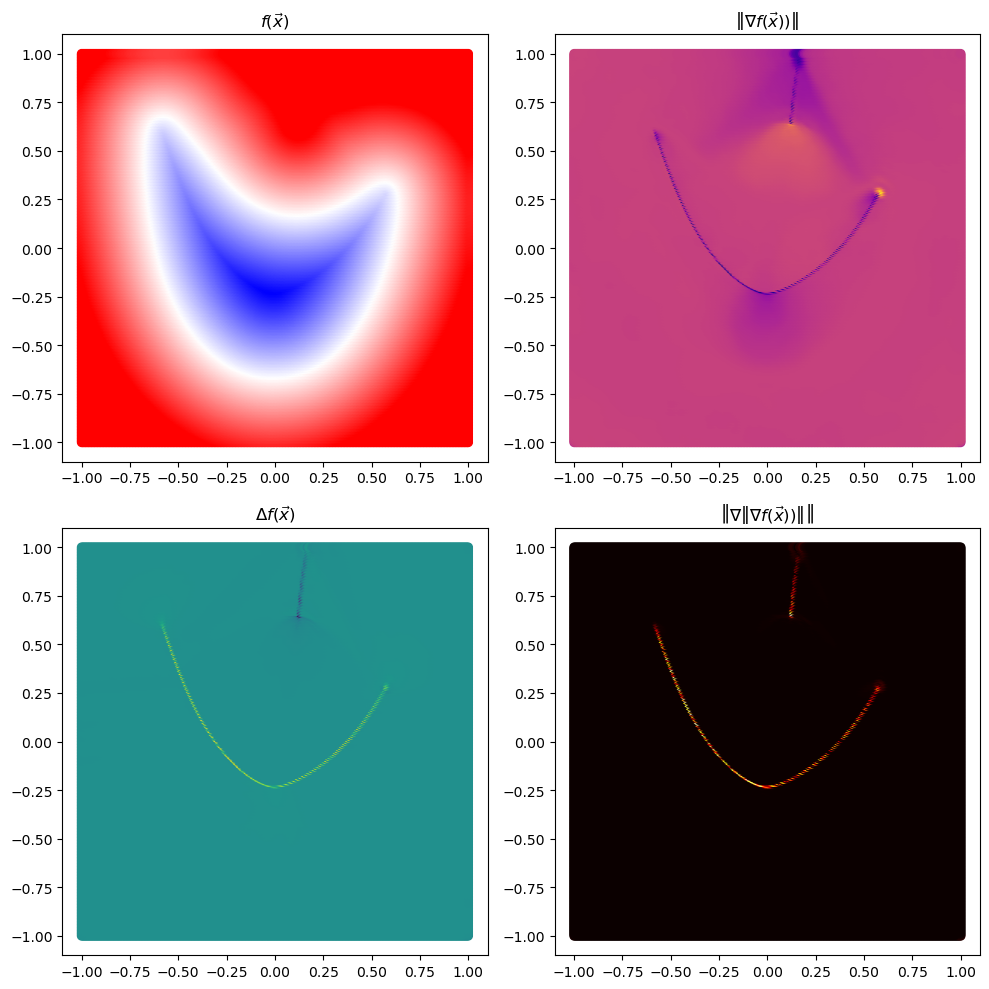

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
clip_val = min( np.abs(np.min(fX)), np.abs(np.max(fX)) )

axs[0][0].scatter(X[:,0], X[:,1], c=fX, cmap='bwr', vmin=-clip_val, vmax= clip_val)
axs[0][1].scatter(X[:,0], X[:,1], c=np.sum( dfX ** 2, axis=1), cmap='plasma')
axs[1][0].scatter(X[:,0], X[:,1], c=LfX, cmap='viridis')
axs[1][1].scatter(X[:,0], X[:,1], c=np.linalg.norm(tv, axis=1), cmap='hot')

axs[0][0].set_title(r'$f(\vec{x})$')
axs[0][1].set_title(r'$\left \| \nabla f(\vec{x}) ) \right \|$')
axs[1][0].set_title(r'$\Delta f(\vec{x})$')
axs[1][1].set_title(r'$\left \| \nabla \left \| \nabla f(\vec{x}) ) \right \|  \right \|$')

plt.tight_layout()
plt.show()

## Discrete Neumann:

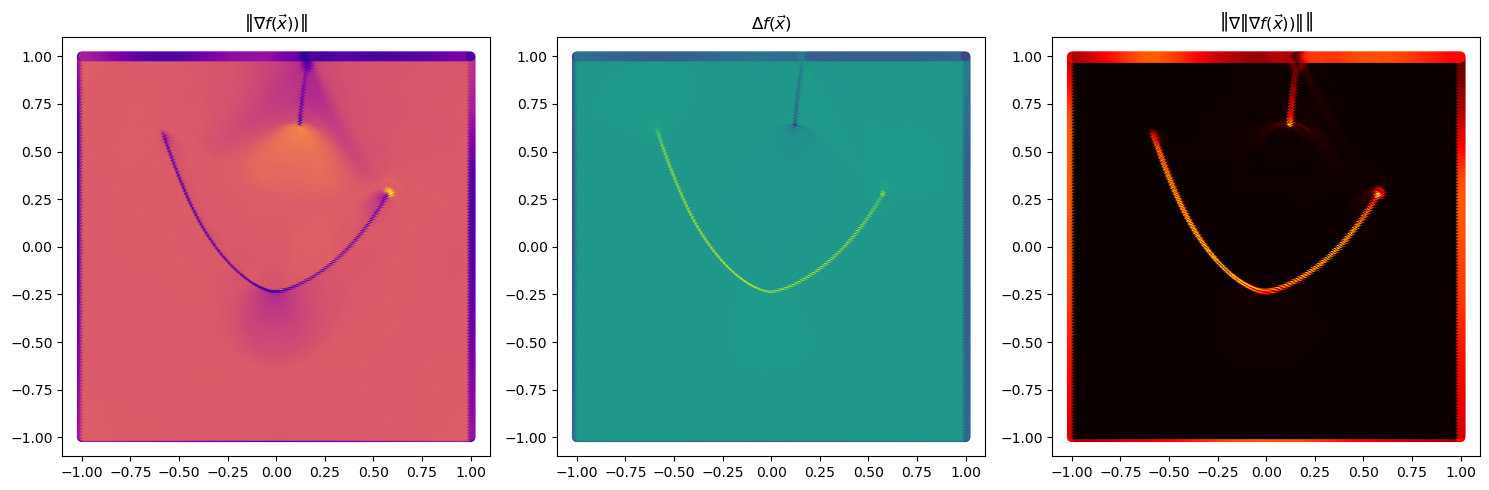

In [36]:
Gx, Gy = gridDx(N, 'neumann'), gridDy(N, 'neumann')
discreteDfXx, discreteDfXy = Gx @ fX, Gy @ fX
gradNorm = discreteDfXx.flatten() ** 2 + discreteDfXy.flatten() ** 2

L = gridLaplacian( N, 'neumann' )
discreteLfX = L @ fX

discreteTV = np.sqrt( (Gx @ gradNorm) ** 2 + (Gy @ gradNorm) ** 2 )

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
clip_val = min( np.abs(np.min(fX)), np.abs(np.max(fX)) )

axs[0].scatter(X[:,0], X[:,1], c=gradNorm, cmap='plasma')
axs[1].scatter(X[:,0], X[:,1], c=discreteLfX, cmap='viridis')
axs[2].scatter(X[:,0], X[:,1], c=discreteTV, cmap='hot')

axs[0].set_title(r'$\left \| \nabla f(\vec{x}) ) \right \|$')
axs[1].set_title(r'$\Delta f(\vec{x})$')
axs[2].set_title(r'$\left \| \nabla \left \| \nabla f(\vec{x}) ) \right \|  \right \|$')

plt.tight_layout()
plt.show()

Diferencias:

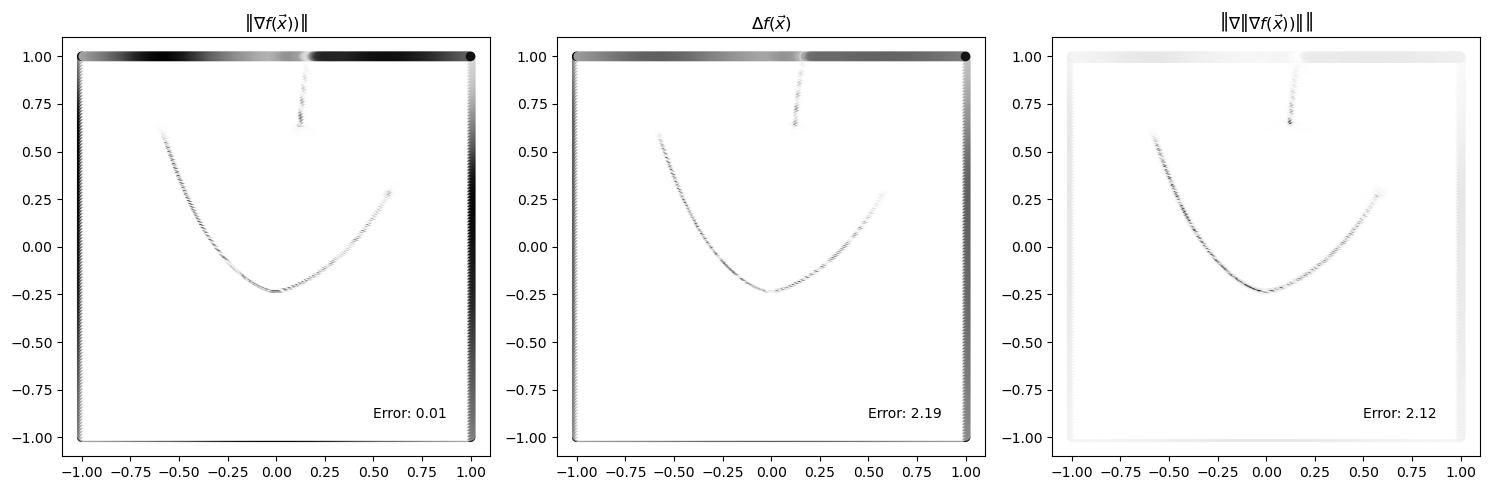

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(X[:,0], X[:,1], c=np.abs( np.sum( dfX ** 2, axis=1) - gradNorm), cmap='Greys')
axs[1].scatter(X[:,0], X[:,1], c=np.abs( LfX - discreteLfX), cmap='Greys')
axs[2].scatter(X[:,0], X[:,1], c=np.abs( np.linalg.norm(tv, axis=1) - discreteTV), cmap='Greys')

axs[0].text(0.5, -0.9, f"Error: {np.mean(np.abs( np.sum( dfX ** 2, axis=1) - gradNorm)):.2f}")
axs[1].text(0.5, -0.9, f"Error: {np.mean(np.abs( LfX - discreteLfX)):.2f}")
axs[2].text(0.5, -0.9, f"Error: {np.mean(np.abs( np.linalg.norm(tv, axis=1) - discreteTV)):.2f}")

axs[0].set_title(r'$\left \| \nabla f(\vec{x}) ) \right \|$')
axs[1].set_title(r'$\Delta f(\vec{x})$')
axs[2].set_title(r'$\left \| \nabla \left \| \nabla f(\vec{x}) ) \right \|  \right \|$')

plt.tight_layout()
plt.show()

## Discrete Dirichlet

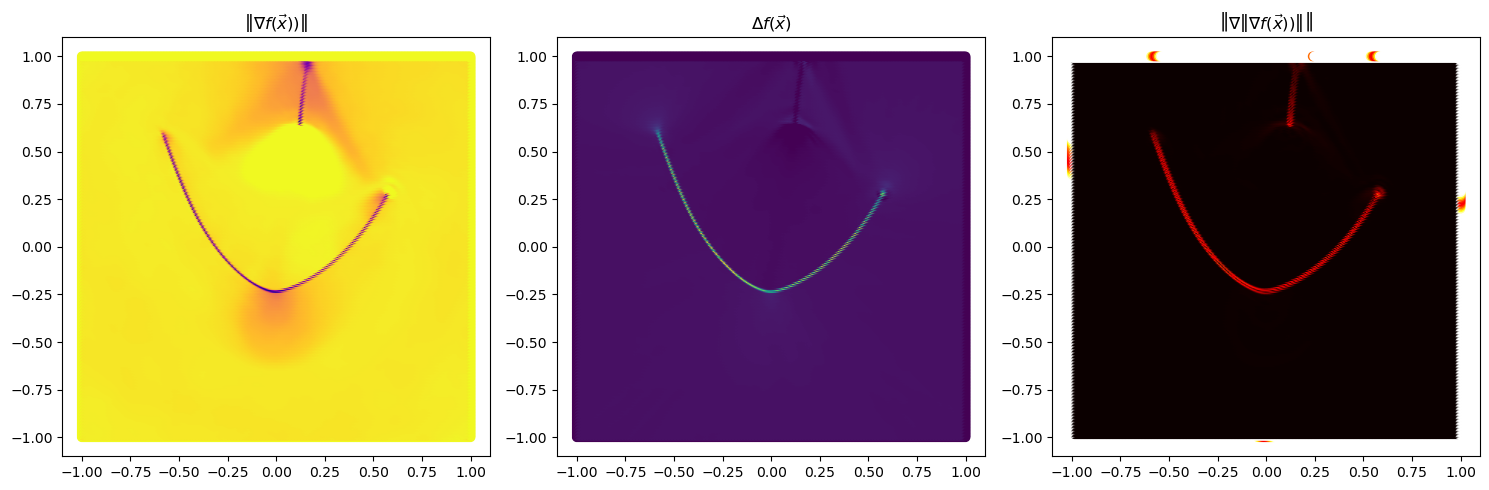

In [40]:
Gx, Gy = gridDx(N, 'dirichlet'), gridDy(N, 'dirichlet')
discreteDfXx, discreteDfXy = Gx @ fX, Gy @ fX
gradNorm = discreteDfXx.flatten() ** 2 + discreteDfXy.flatten() ** 2

L = gridLaplacian( N, 'dirichlet' )
discreteLfX = L @ fX

discreteTV = np.sqrt( (Gx @ gradNorm) ** 2 + (Gy @ gradNorm) ** 2 )

gradNorm = np.clip( gradNorm, np.percentile(gradNorm ,0), np.percentile(gradNorm , 95))
discreteLfX = np.clip( discreteLfX, np.percentile(discreteLfX ,2), np.percentile(discreteLfX , 100))
discreteTV = np.clip( discreteTV, np.percentile(discreteTV ,0), np.percentile(discreteTV , 97))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(X[:,0], X[:,1], c=gradNorm, cmap='plasma')
axs[1].scatter(X[:,0], X[:,1], c=discreteLfX, cmap='viridis')
axs[2].scatter(X[:,0], X[:,1], c=discreteTV, cmap='hot')

axs[0].set_title(r'$\left \| \nabla f(\vec{x}) ) \right \|$')
axs[1].set_title(r'$\Delta f(\vec{x})$')
axs[2].set_title(r'$\left \| \nabla \left \| \nabla f(\vec{x}) ) \right \|  \right \|$')

plt.tight_layout()
plt.show()

Diferencias:

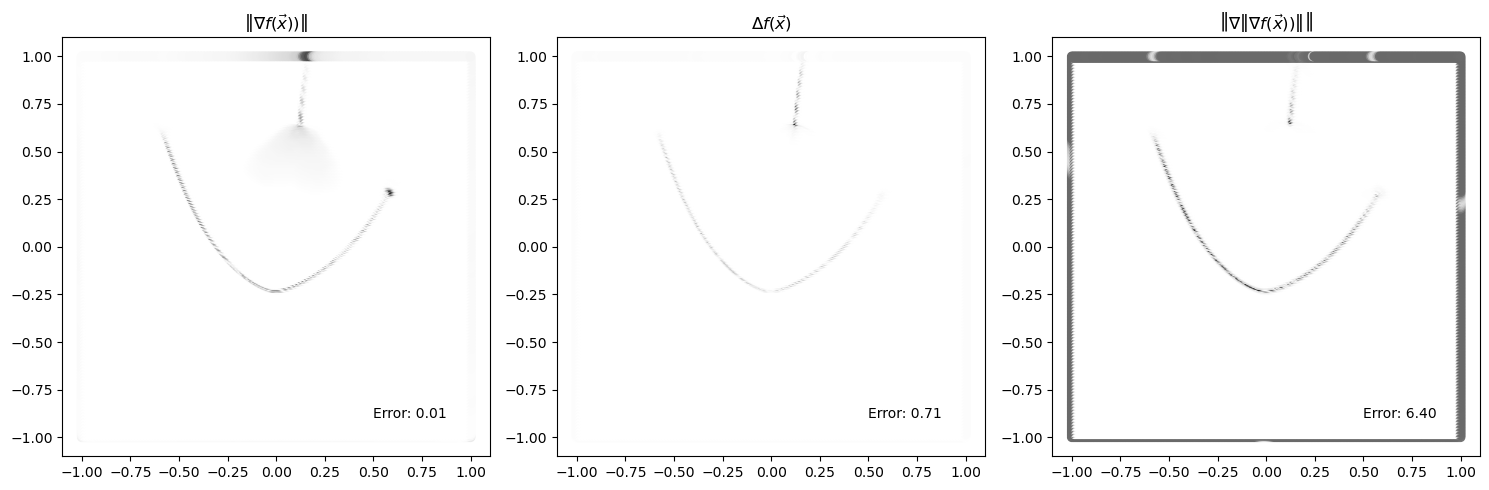

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(X[:,0], X[:,1], c=np.abs( np.sum( dfX ** 2, axis=1) - gradNorm), cmap='Greys')
axs[1].scatter(X[:,0], X[:,1], c=np.abs( LfX - discreteLfX), cmap='Greys')
axs[2].scatter(X[:,0], X[:,1], c=np.abs( np.linalg.norm(tv, axis=1) - discreteTV), cmap='Greys')

axs[0].text(0.5, -0.9, f"Error: {np.mean(np.abs( np.sum( dfX ** 2, axis=1) - gradNorm)):.2f}")
axs[1].text(0.5, -0.9, f"Error: {np.mean(np.abs( LfX - discreteLfX)):.2f}")
axs[2].text(0.5, -0.9, f"Error: {np.mean(np.abs( np.linalg.norm(tv, axis=1) - discreteTV)):.2f}")

axs[0].set_title(r'$\left \| \nabla f(\vec{x}) ) \right \|$')
axs[1].set_title(r'$\Delta f(\vec{x})$')
axs[2].set_title(r'$\left \| \nabla \left \| \nabla f(\vec{x}) ) \right \|  \right \|$')

plt.tight_layout()
plt.show()

## Discrete second order

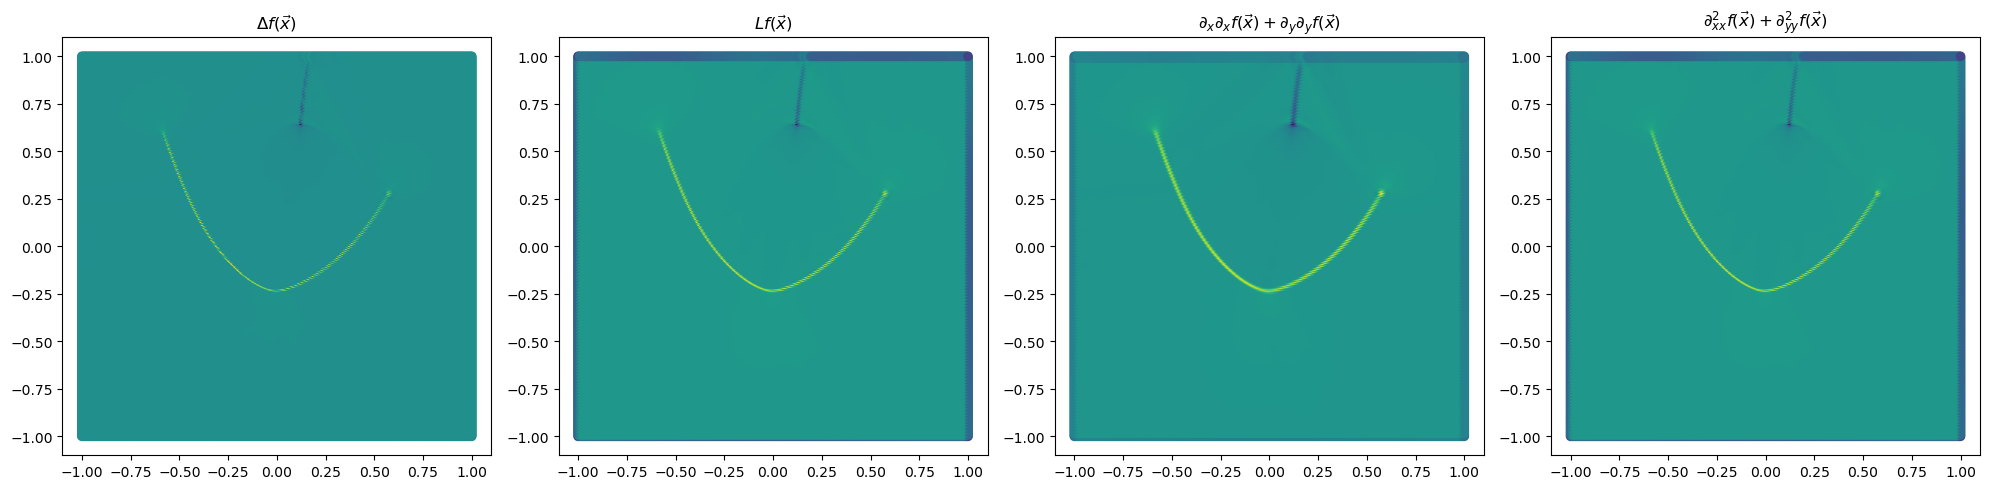

In [23]:
L = gridLaplacian( N, 'neumann' )
discreteLfX = L @ fX

Gx, Gy = gridDx(N, 'neumann'), gridDy(N, 'neumann')
discreteDfXx, discreteDfXy = Gx @ fX, Gy @ fX

Gxx, Gyy = gridDxx(N, 'neumann'), gridDyy(N, 'neumann')
discreteDfXxx, discreteDfXyy = Gxx @ fX, Gyy @ fX

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].scatter(X[:,0], X[:,1], c=LfX, cmap='viridis')
axs[1].scatter(X[:,0], X[:,1], c=discreteLfX, cmap='viridis')
axs[2].scatter(X[:,0], X[:,1], c=Gx @ discreteDfXx + Gy @ discreteDfXy, cmap='viridis')
axs[3].scatter(X[:,0], X[:,1], c=discreteDfXxx + discreteDfXyy, cmap='viridis')

axs[0].set_title(r'$\Delta f(\vec{x})$')
axs[1].set_title(r'$L f(\vec{x})$')
axs[2].set_title(r'$\partial_x \partial_x f(\vec{x}) + \partial_y \partial_y f(\vec{x})$')
axs[3].set_title(r'$\partial_{xx}^2 f(\vec{x}) + \partial_{yy}^2 f(\vec{x})$')

plt.tight_layout()
plt.show()

Diferencias:

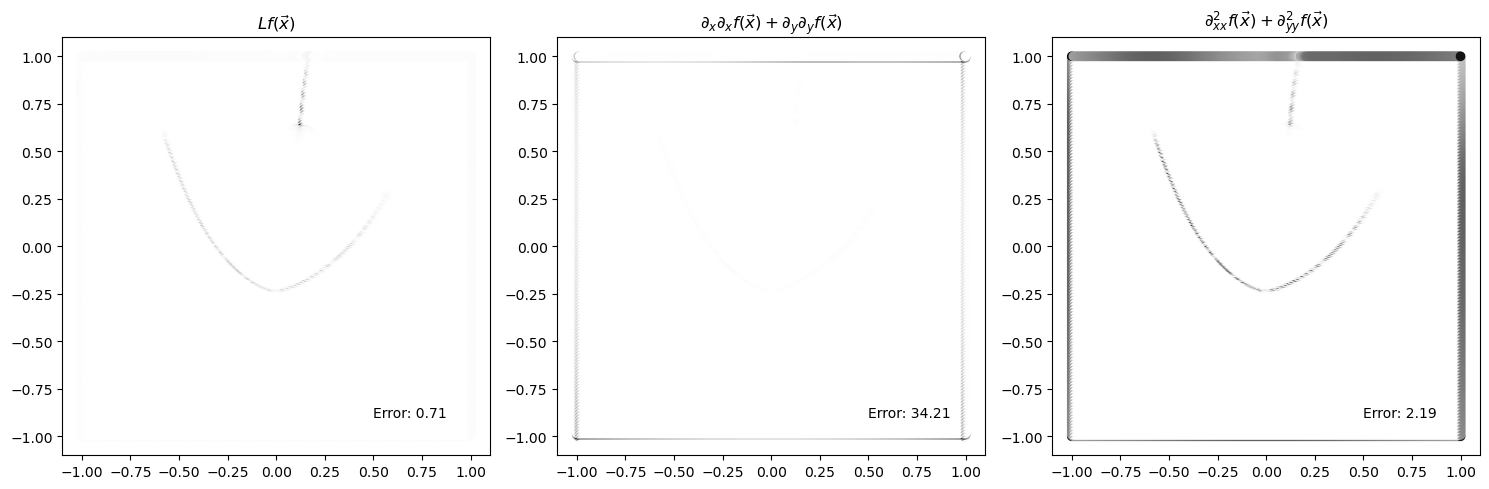

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(X[:,0], X[:,1], c=np.abs(LfX - discreteLfX), cmap='Greys')
axs[1].scatter(X[:,0], X[:,1], c=np.abs(LfX - (Gx @ discreteDfXx + Gy @ discreteDfXy)), cmap='Greys')
axs[2].scatter(X[:,0], X[:,1], c=np.abs(LfX - (discreteDfXxx + discreteDfXyy)), cmap='Greys')

axs[0].text(0.5, -0.9, f"Error: {np.mean(np.abs(LfX - discreteLfX)):.2f}")
axs[1].text(0.5, -0.9, f"Error: {np.mean(np.abs(LfX - (Gx @ discreteDfXx + Gy @ discreteDfXy))):.2f}")
axs[2].text(0.5, -0.9, f"Error: {np.mean(np.abs(LfX - (discreteDfXxx + discreteDfXyy))):.2f}")

axs[0].set_title(r'$L f(\vec{x})$')
axs[1].set_title(r'$\partial_x \partial_x f(\vec{x}) + \partial_y \partial_y f(\vec{x})$')
axs[2].set_title(r'$\partial_{xx}^2 f(\vec{x}) + \partial_{yy}^2 f(\vec{x})$')

plt.tight_layout()
plt.show()